## Import datasets

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
from model_LN import *
from utils import *

## Data transformation

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(28), ], p = 0.1),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_data = datasets.CIFAR10(root=".", train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               RandomApply(
               p=0.1
               CenterCrop(size=(28, 28))
           )
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
           )

In [6]:
classes = train_data.classes

class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


In [7]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

## Sample image

images.shape: torch.Size([128, 3, 32, 32])


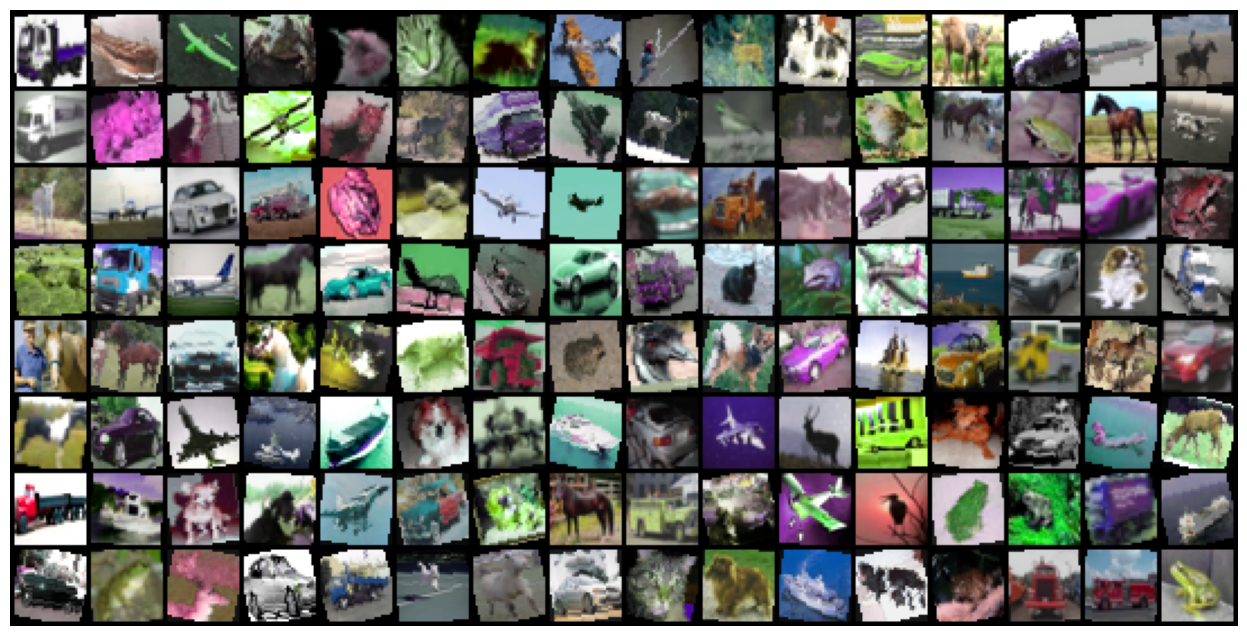

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Neural net summary

In [9]:
get_summary(Net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         LayerNorm-3           [-1, 16, 32, 32]           2,048
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           3,456
              ReLU-6           [-1, 24, 32, 32]               0
         LayerNorm-7           [-1, 24, 32, 32]           2,048
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             192
             ReLU-10            [-1, 8, 32, 32]               0
        LayerNorm-11            [-1, 8, 32, 32]           2,048
          Dropout-12            [-1, 8, 32, 32]               0
        MaxPool2d-13            [-1, 8, 16, 16]               0
           Conv2d-14           [-1, 16,

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

## Training the data and calculating validation results

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# New Line
train_criterion = nn.CrossEntropyLoss() #Loss function
test_criterion = nn.CrossEntropyLoss() #Loss function
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, train_criterion)
    print(train_acc_val)
    test_acc_val, test_loss = test(model, device, test_loader, test_criterion)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

Epoch 1


Train: Loss=1.9919 Batch_id=390 Accuracy=18.06: 100%|█| 391/391 [01:30<00:00,  4

18.062


Test set: Average loss: 1.8074, Accuracy: 3432/10000 (34.32%)

Epoch 1: SGD lr 0.0500 -> 0.0400
Epoch 2


Train: Loss=1.8005 Batch_id=390 Accuracy=37.74: 100%|█| 391/391 [01:32<00:00,  4

37.738


Test set: Average loss: 1.5402, Accuracy: 4428/10000 (44.28%)

Epoch 2: SGD lr 0.0400 -> 0.0320
Epoch 3


Train: Loss=1.4665 Batch_id=390 Accuracy=44.84: 100%|█| 391/391 [01:32<00:00,  4

44.844


Test set: Average loss: 1.3960, Accuracy: 4980/10000 (49.80%)

Epoch 3: SGD lr 0.0320 -> 0.0256
Epoch 4


Train: Loss=1.3893 Batch_id=390 Accuracy=49.19: 100%|█| 391/391 [01:32<00:00,  4

49.194


Test set: Average loss: 1.2808, Accuracy: 5354/10000 (53.54%)

Epoch 4: SGD lr 0.0256 -> 0.0205
Epoch 5


Train: Loss=1.1810 Batch_id=390 Accuracy=51.58: 100%|█| 391/391 [01:39<00:00,  3

51.576


Test set: Average loss: 1.1945, Accuracy: 5713/10000 (57.13%)

Epoch 5: SGD lr 0.0205 -> 0.0164
Epoch 6


Train: Loss=1.0921 Batch_id=390 Accuracy=53.60: 100%|█| 391/391 [01:33<00:00,  4

53.602


Test set: Average loss: 1.1390, Accuracy: 5936/10000 (59.36%)

Epoch 6: SGD lr 0.0164 -> 0.0131
Epoch 7


Train: Loss=1.3325 Batch_id=390 Accuracy=55.42: 100%|█| 391/391 [01:35<00:00,  4

55.424


Test set: Average loss: 1.1177, Accuracy: 6029/10000 (60.29%)

Epoch 7: SGD lr 0.0131 -> 0.0105
Epoch 8


Train: Loss=1.3290 Batch_id=390 Accuracy=56.56: 100%|█| 391/391 [01:33<00:00,  4

56.558


Test set: Average loss: 1.0813, Accuracy: 6164/10000 (61.64%)

Epoch 8: SGD lr 0.0105 -> 0.0084
Epoch 9


Train: Loss=0.9670 Batch_id=390 Accuracy=57.79: 100%|█| 391/391 [01:37<00:00,  4

57.792


Test set: Average loss: 1.0731, Accuracy: 6265/10000 (62.65%)

Epoch 9: SGD lr 0.0084 -> 0.0067
Epoch 10


Train: Loss=0.9628 Batch_id=390 Accuracy=58.37: 100%|█| 391/391 [01:35<00:00,  4

58.37


Test set: Average loss: 1.0427, Accuracy: 6295/10000 (62.95%)

Epoch 10: SGD lr 0.0067 -> 0.0054
Epoch 11


Train: Loss=1.2765 Batch_id=390 Accuracy=59.15: 100%|█| 391/391 [01:39<00:00,  3

59.15


Test set: Average loss: 1.0247, Accuracy: 6406/10000 (64.06%)

Epoch 11: SGD lr 0.0054 -> 0.0043
Epoch 12


Train: Loss=1.0173 Batch_id=390 Accuracy=59.37: 100%|█| 391/391 [01:39<00:00,  3

59.37


Test set: Average loss: 1.0305, Accuracy: 6363/10000 (63.63%)

Epoch 12: SGD lr 0.0043 -> 0.0034
Epoch 13


Train: Loss=1.1848 Batch_id=390 Accuracy=59.97: 100%|█| 391/391 [01:36<00:00,  4

59.966


Test set: Average loss: 1.0040, Accuracy: 6469/10000 (64.69%)

Epoch 13: SGD lr 0.0034 -> 0.0027
Epoch 14


Train: Loss=1.0637 Batch_id=390 Accuracy=60.12: 100%|█| 391/391 [01:40<00:00,  3

60.122


Test set: Average loss: 1.0046, Accuracy: 6438/10000 (64.38%)

Epoch 14: SGD lr 0.0027 -> 0.0022
Epoch 15


Train: Loss=0.9461 Batch_id=390 Accuracy=60.77: 100%|█| 391/391 [01:36<00:00,  4

60.772


Test set: Average loss: 0.9977, Accuracy: 6508/10000 (65.08%)

Epoch 15: SGD lr 0.0022 -> 0.0018
Epoch 16


Train: Loss=1.0818 Batch_id=390 Accuracy=60.50: 100%|█| 391/391 [01:37<00:00,  4

60.496


Test set: Average loss: 0.9889, Accuracy: 6503/10000 (65.03%)

Epoch 16: SGD lr 0.0018 -> 0.0014
Epoch 17


Train: Loss=1.0430 Batch_id=390 Accuracy=61.09: 100%|█| 391/391 [01:38<00:00,  3

61.09


Test set: Average loss: 0.9845, Accuracy: 6523/10000 (65.23%)

Epoch 17: SGD lr 0.0014 -> 0.0011
Epoch 18


Train: Loss=1.1442 Batch_id=390 Accuracy=61.20: 100%|█| 391/391 [01:46<00:00,  3

61.198


Test set: Average loss: 0.9822, Accuracy: 6523/10000 (65.23%)

Epoch 18: SGD lr 0.0011 -> 0.0009
Epoch 19


Train: Loss=1.1349 Batch_id=390 Accuracy=61.12: 100%|█| 391/391 [01:40<00:00,  3

61.118


Test set: Average loss: 0.9771, Accuracy: 6557/10000 (65.57%)

Epoch 19: SGD lr 0.0009 -> 0.0007
Epoch 20


Train: Loss=1.2414 Batch_id=390 Accuracy=61.20: 100%|█| 391/391 [01:39<00:00,  3

61.196


Test set: Average loss: 0.9779, Accuracy: 6547/10000 (65.47%)

Epoch 20: SGD lr 0.0007 -> 0.0006


## Plots

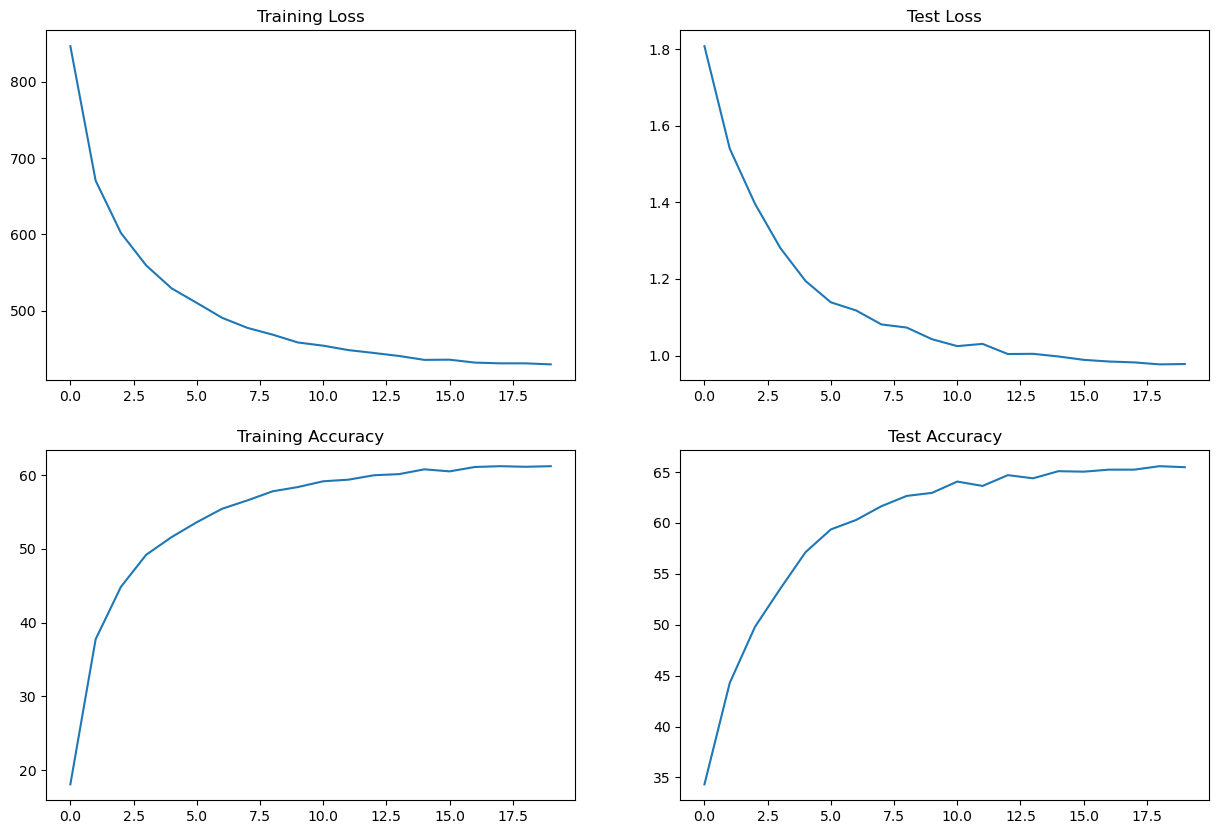

In [12]:
plot_loss(train_losses, train_acc, test_losses, test_acc)

## Misclassified dataset

In [13]:
model.eval()

incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): 
        incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
        incorrect_labels.append(target[idxs_mask].cpu().numpy())
        incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy())

In [14]:
print(incorrect_labels[0])
print(incorrect_pred[0])

[3 6 3 7 3 6 8 4 2 7 3 2 7 4 5 6 2 8 2 6 1 1 5 7 8 7 8 3 5 8 2 2 6 8 4 8 3
 7 3 2 8 6 1 4 3 5]
[5 3 2 0 4 3 0 6 4 5 5 6 3 2 6 9 5 1 3 0 7 9 7 5 0 5 0 4 0 2 7 3 9 0 8 0 5
 6 4 0 1 5 9 8 2 2]


In [15]:
print(incorrect_examples[0][0])

[[[0.7294118  0.43137255 0.35686275 ... 0.42745098 0.43529412 0.4509804 ]
  [0.74509805 0.4392157  0.40784314 ... 0.4392157  0.4392157  0.4509804 ]
  [0.79607844 0.47058824 0.42352942 ... 0.4392157  0.44313726 0.45882353]
  ...
  [0.85490197 0.87058824 0.8784314  ... 0.1254902  0.11764706 0.10588235]
  [0.76862746 0.7764706  0.7764706  ... 0.1254902  0.12941177 0.11372549]
  [0.43137255 0.43137255 0.42352942 ... 0.13725491 0.14117648 0.12156863]]

 [[0.69411767 0.35686275 0.16470589 ... 0.41960785 0.42745098 0.44313726]
  [0.69411767 0.3882353  0.21176471 ... 0.43137255 0.43137255 0.44313726]
  [0.7019608  0.40784314 0.20784314 ... 0.43137255 0.43529412 0.44705883]
  ...
  [0.6039216  0.59607846 0.6156863  ... 0.20784314 0.20392157 0.1882353 ]
  [0.54509807 0.54509807 0.5647059  ... 0.20784314 0.21176471 0.2       ]
  [0.2627451  0.25882354 0.2784314  ... 0.21176471 0.21960784 0.2       ]]

 [[0.68235296 0.33333334 0.09803922 ... 0.4627451  0.47058824 0.4862745 ]
  [0.6784314  0.384313

## Sample Misclassified Images

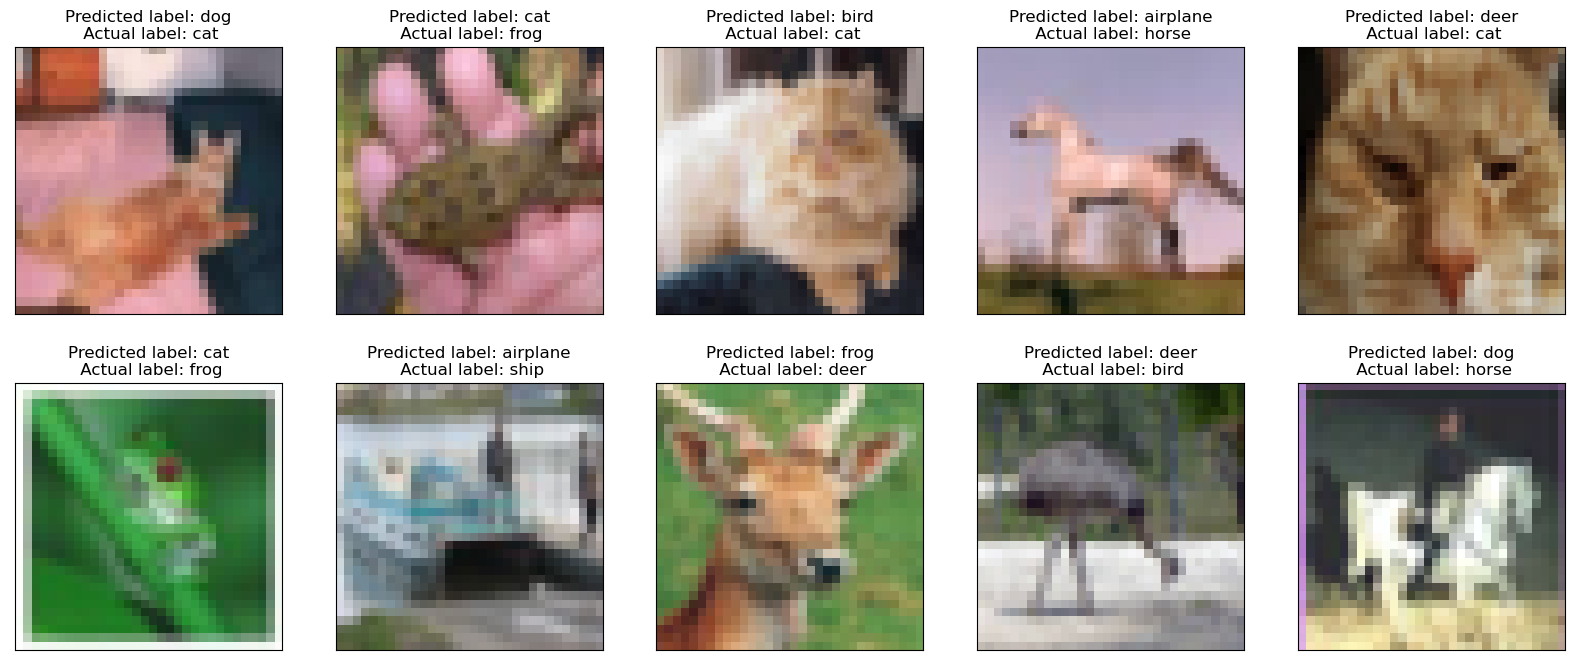

In [16]:
import numpy as np
fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = incorrect_examples[0][idx]
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(incorrect_examples[0][idx], (1, 2, 0)))
    ax.set_title(f"Predicted label: {classes[incorrect_pred[0][idx]]}\n Actual label: {classes[incorrect_labels[0][idx]]}")
    